using https://github.com/DataTalksClub/llm-zoomcamp/blob/main/04-monitoring/offline-rag-evaluation.ipynb

## Load documents with IDs

In [13]:
import requests 

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [14]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

## Load ground truth

In [15]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [16]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [17]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Index data

In [18]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
encoding_model = SentenceTransformer(model_name)


/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/python/3.12.1/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [19]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [20]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = encoding_model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 948/948 [01:16<00:00, 12.36it/s]


## Retrieval

In [21]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']
    v_q = encoding_model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [22]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

## The RAG flow

In [23]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

# donot have access to openai gpt 4 using jamba

In [25]:
# from openai import OpenAI

# client = OpenAI()

# def llm(prompt, model='gpt-4o'):
#     response = client.chat.completions.create(
#         model=model,
#         messages=[{"role": "user", "content": prompt}]
#     )https://parlance-labs.com/education/
    
#     return response.choices[0].message.content

    # rag: generation 
from ai21 import AI21Client
from ai21.models.chat import UserMessage

# One way of passing your key to the client.
import os
import json
AI21_API_KEY = os.environ["AI21_API_KEY"]
j_client = AI21Client(api_key=AI21_API_KEY)

def single_message_instruct(content,model="jamba-1.5-large"):
    messages = [UserMessage(content=content)]
    response = j_client.chat.completions.create(
        model=model,
        messages=messages,
        top_p=1.0 # Setting to 1 encourages different responses each call.
    )
    return response.to_json()

def llm(prompt,model="jamba-1.5-large"):
    response = single_message_instruct(prompt,model)
    json_response = json.loads(response)
    content = json_response["choices"][0]["message"]["content"]
    return content

In [26]:
# previously: rag(query: str) -> str
def rag(query: dict,model="jamba-1.5-large") -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [27]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [28]:
rag(ground_truth[10])

/tmp/ipykernel_5312/2269821981.py:32: DeprecationWarning: The 'to_json' method is deprecated and will be removed in a future version. Please use Pydantic's built-in methods instead.
  return response.to_json()


'Yes. Everything is recorded, including the office hours. You can access the recordings in the course playlist on YouTube.'

In [29]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Cosine similarity metric

In [30]:
answer_orig = 'Yes, sessions are recorded if you miss one. Everything is recorded, allowing you to catch up on any missed content. Additionally, you can ask questions in advance for office hours and have them addressed during the live stream. You can also ask questions in Slack.'
answer_llm = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

v_llm = encoding_model.encode(answer_llm)
v_orig = encoding_model.encode(answer_orig)

v_llm.dot(v_orig)

np.float32(0.7591172)

In [31]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [32]:
len(ground_truth)

1830

In [ ]:

answers = {}
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [36]:
# jamba
results_jamba = [None] * len(ground_truth)

for i, val in answers.items():
    results_jamba[i] = val.copy()
    results_jamba[i].update(ground_truth[i])

In [37]:
import pandas as pd

In [38]:
df_jamba = pd.DataFrame(results_jamba)

In [39]:
!mkdir data

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [40]:
df_jamba.to_csv('data/results-jamba.csv', index=False)

In [129]:
df_jamba=pd.read_csv('data/results-jamba.csv')

## Evaluating jamba-1.5-mini

In [120]:
rag(ground_truth[10], model='jamba-1.5-mini')

/tmp/ipykernel_70444/772982698.py:30: DeprecationWarning: The 'to_json' method is deprecated and will be removed in a future version. Please use Pydantic's built-in methods instead.
  return response.to_json()


'Yes, everything is recorded, so you won’t miss anything. You can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.'

from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=2)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

def process_record(rec):
    model = 'jamba-1.5-mini'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

process_record(ground_truth[10])

results_jamba_1_5_mini = map_progress(pool, ground_truth, process_record)

In [121]:
answers = {}
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec, model='jamba-1.5-mini')
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

  0%|                                                                                                                                          | 0/1830 [00:00<?, ?it/s]/tmp/ipykernel_70444/772982698.py:30: DeprecationWarning: The 'to_json' method is deprecated and will be removed in a future version. Please use Pydantic's built-in methods instead.
  return response.to_json()
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [39:22<00:00,  1.29s/it]


In [145]:
# jamba
results_jamba_mini = [None] * len(ground_truth)

for i, val in answers.items():
    results_jamba_mini[i] = val.copy()
    results_jamba_mini[i].update(ground_truth[i])

In [146]:
df_jamba_mini = pd.DataFrame(results_jamba_mini)
df_jamba_mini.to_csv('data/results-jamba_1_5_mini.csv', index=False)

In [148]:
!head data/results-jamba_1_5_mini.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


answer_llm,answer_orig,document,question,course
"Yes. You can sign up for the course on the course page (http://mlzoomcamp.com/), scroll down and start going through the course materials.","Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:
Data Engineering Zoomcamp FAQ
In the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo
work",0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
Answer: You can sign up for the Machine Learning Zoomcamp by following the link provided in the GitHub repository: https://airtable.com/shryxwLd0COOEaqXo.,"Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Ch

## Cosine similarity

A->Q->A' cosine similarity

A -> Q -> A'

cosine(A, A')

### jamba

In [57]:
results_jamba = df_jamba.to_dict(orient='records')

In [58]:
record = results_jamba[0]

In [59]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = encoding_model.encode(answer_llm)
    v_orig = encoding_model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [60]:
similarity = []

for record in tqdm(results_jamba):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [02:17<00:00, 13.28it/s]


In [61]:
df_jamba['cosine'] = similarity
df_jamba['cosine'].describe()

count    1830.000000
mean        0.633089
std         0.266189
min        -0.118290
25%         0.500705
50%         0.701253
75%         0.830868
max         1.000000
Name: cosine, dtype: float64

In [62]:
import seaborn as sns

/tmp/ipykernel_5312/1437543302.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_jamba['cosine'], label='jamba')


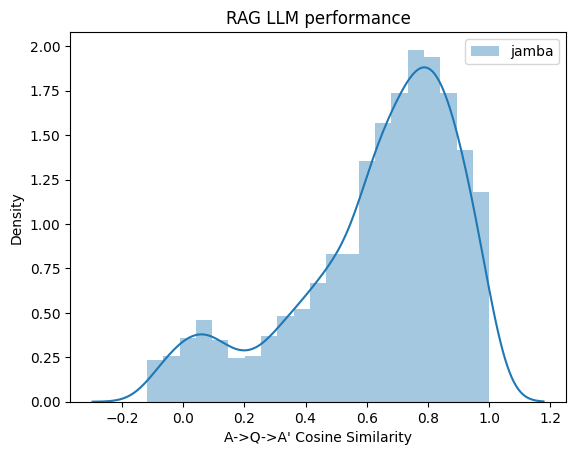

In [63]:
# sns.distplot(df_gpt35['cosine'], label='3.5')
import matplotlib.pyplot as plt
sns.distplot(df_jamba['cosine'], label='jamba')
plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

### jamba-mini

In [66]:
# df_jamba_mini= pd.read_csv('data/results-jamba_1_5_mini.csv')

In [67]:
results_jamba_mini = df_jamba_mini.to_dict(orient='records')

similarity_mini = []

for record in tqdm(results_jamba_mini):
    sim = compute_similarity(record)
    similarity_mini.append(sim)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1830/1830 [02:23<00:00, 12.77it/s]


In [68]:
df_jamba_mini['cosine'] = similarity_mini
df_jamba_mini['cosine'].describe()

count    1830.000000
mean        0.610790
std         0.266237
min        -0.155983
25%         0.486193
50%         0.684501
75%         0.808150
max         1.000000
Name: cosine, dtype: float64

/tmp/ipykernel_5312/3177042176.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_jamba['cosine'], label='jamba')
/tmp/ipykernel_5312/3177042176.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_jamba_mini['cosine'], label='jamba-mini')


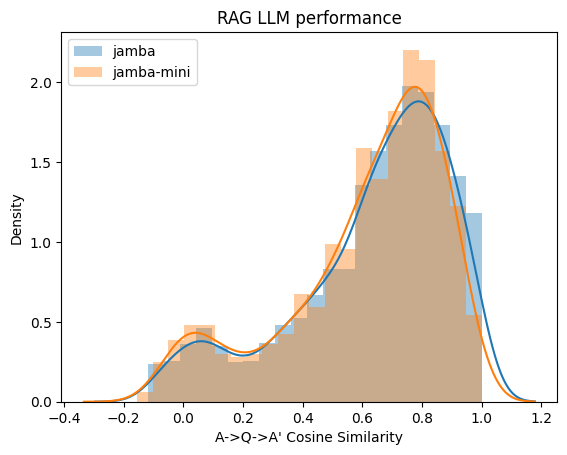

In [69]:
import matplotlib.pyplot as plt
# sns.distplot(df_gpt35['cosine'], label='3.5')

sns.distplot(df_jamba['cosine'], label='jamba')
sns.distplot(df_jamba_mini['cosine'], label='jamba-mini')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

### gpt-4o-mini

def process_record_4o_mini(rec):
    model = 'gpt-4o-mini'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

process_record_4o_mini(ground_truth[10])

results_gpt4omini = []

for record in tqdm(ground_truth):
    result = process_record_4o_mini(record)
    results_gpt4omini.append(result)

df_gpt4o_mini = pd.DataFrame(results_gpt4omini)
df_gpt4o_mini.to_csv('data/results-gpt4o-mini.csv', index=False)

similarity_4o_mini = []

for record in tqdm(results_gpt4omini):
    sim = compute_similarity(record)
    similarity_4o_mini.append(sim)

df_gpt4o_mini['cosine'] = similarity_4o_mini
df_gpt4o_mini['cosine'].describe()

gpt4o 

```
count    1830.000000
mean        0.679129
std         0.217995
min        -0.153426
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64
```

In [5]:
# import pandas as pd
# df_jamba = pd.read_csv('data/results-jamba.csv')

## LLM-as-a-Judge

In [33]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [34]:
df_sample = df_jamba.sample(n=150, random_state=1)

In [35]:
samples = df_sample.to_dict(orient='records')

In [36]:
record = samples[0]
record

{'answer_llm': 'The syntax for using precision_recall_fscore_support in Python is as follows:\n\n```python\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n```',
 'answer_orig': 'Scikit-learn offers another way: precision_recall_fscore_support\nExample:\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n(Gopakumar Gopinathan)',
 'document': '403bbdd8',
 'question': 'What is the syntax for using precision_recall_fscore_support in Python?',
 'course': 'machine-learning-zoomcamp'}

In [37]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Scikit-learn offers another way: precision_recall_fscore_support
Example:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
(Gopakumar Gopinathan)
Generated Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using precision_recall_fscore_support in Python is as follows:

```python
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pr

In [39]:
answer = llm(prompt, model='jamba-1.5-large')

/tmp/ipykernel_5312/2269821981.py:32: DeprecationWarning: The 'to_json' method is deprecated and will be removed in a future version. Please use Pydantic's built-in methods instead.
  return response.to_json()


In [40]:
import json

In [42]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='jamba-1.5-large')
    evaluations.append(evaluation)

  0%|                                                                                                                                           | 0/150 [00:00<?, ?it/s]/tmp/ipykernel_5312/2269821981.py:32: DeprecationWarning: The 'to_json' method is deprecated and will be removed in a future version. Please use Pydantic's built-in methods instead.
  return response.to_json()
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [05:40<00:00,  2.27s/it]


In [43]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [44]:
df_evaluations = pd.DataFrame(json_evaluations)

In [45]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           110
PARTLY_RELEVANT     25
NON_RELEVANT        15
Name: count, dtype: int64

In [46]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')

,Relevance,Explanation
4,NON_RELEVANT,The generated answer does not address the orig...
11,NON_RELEVANT,The generated answer suggests downgrading the ...
22,NON_RELEVANT,The generated answer incorrectly identifies Di...
27,NON_RELEVANT,The generated answer does not address the ques...
43,NON_RELEVANT,The generated answer suggests checking Docker ...
49,NON_RELEVANT,The generated answer does not provide a link t...
69,NON_RELEVANT,The generated answer does not address the orig...
87,NON_RELEVANT,The generated answer does not address the orig...
93,NON_RELEVANT,The generated answer does not address the orig...
112,NON_RELEVANT,The generated answer does not address the role...


In [48]:
prompt = prompt2_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: What modification was made to the median_house_value target in the homework?
Generated Answer: The target variable, median_house_value, was changed to binary format, making its values discrete as either 0 or 1.

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}


In [49]:
evaluation = llm(prompt, model='jamba-1.5-large')
print(evaluation)

{
  "Relevance": "RELEVANT",
  "Explanation": "The answer correctly identifies that the median_house_value target was changed to a binary format, with values represented as either 0 or 1. This modification is accurately described as making the values discrete."
}


/tmp/ipykernel_5312/2269821981.py:32: DeprecationWarning: The 'to_json' method is deprecated and will be removed in a future version. Please use Pydantic's built-in methods instead.
  return response.to_json()


In [50]:
evaluations_2 = []

for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model='jamba-1.5-large')
    evaluations_2.append(evaluation)

  0%|                                                                                                                                           | 0/150 [00:00<?, ?it/s]/tmp/ipykernel_5312/2269821981.py:32: DeprecationWarning: The 'to_json' method is deprecated and will be removed in a future version. Please use Pydantic's built-in methods instead.
  return response.to_json()
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [05:15<00:00,  2.11s/it]


In [51]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

In [52]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)

In [53]:
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
27,NON_RELEVANT,The question is asking for an alternative comm...
53,NON_RELEVANT,The generated answer does not address the issu...
64,NON_RELEVANT,The generated answer is incorrect. A negative ...
66,NON_RELEVANT,The generated answer is non-relevant as it pro...
69,NON_RELEVANT,The generated answer does not provide the spec...
97,NON_RELEVANT,The answer '2560' is not relevant to the quest...
98,NON_RELEVANT,The generated answer does not address the ques...
102,NON_RELEVANT,The generated answer provides a generic soluti...
117,NON_RELEVANT,The generated answer does not address the spec...
137,NON_RELEVANT,The question asks for the basic syntax to copy...


In [54]:
samples[45]

{'answer_llm': 'To start the Docker daemon on Linux, you can use the following commands:\n\n```sh\nsudo systemctl start docker\nsudo systemctl enable docker\n```\n\nThe first command starts the Docker daemon, and the second command ensures that the Docker daemon starts on boot.',
 'answer_orig': 'Working on getting Docker installed - when I try running hello-world I am getting the error.\nDocker: Cannot connect to the docker daemon at unix:///var/run/docker.sock. Is the Docker daemon running ?\nSolution description\nIf you’re getting this error on WSL, re-install your docker: remove the docker installation from WSL and install Docker Desktop on your host machine (Windows).\nOn Linux, start the docker daemon with either of these commands:\nsudo dockerd\nsudo service docker start\nAdded by Ugochukwu Onyebuchi',
 'document': '4b2a3181',
 'question': 'What commands should I use to start the docker daemon on Linux?',
 'course': 'machine-learning-zoomcamp'}

## Saving all the data

In [71]:
df_jamba.to_csv('data/results-jamba-cosine.csv', index=False)
df_jamba_mini.to_csv('data/results-jamba_1_5_mini-cosine.csv', index=False)


In [72]:
df_evaluations.to_csv('data/evaluations-aqa.csv', index=False)
df_evaluations_2.to_csv('data/evaluations-qa.csv', index=False)